# Deploy and Run Pixtral 12B from Amazon Bedrock Marketplace

This is an accompanying notebook of AWS Blog on Pixtral 12B model usage via Amazon Bedrock Marketplace. 

## Setup Dependencies

This notebook uses boto3 and sagemaker modules. Make sure latest versions are installed

In [1]:
%pip install --upgrade pip
%pip install botocore boto3 sagemaker --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the necessary libraries for grabbing sagemaker execution role, bedrock and bedrock runtime API operations

In [2]:
import boto3
import json
import sagemaker
import time
from PIL import Image
from botocore.exceptions import ClientError

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Deploy Model from Bedrock Marketplace


You can discover and deploy Bedrock Marketplace models using AWS Console, Bedrock SDK and AWS CLI. This notebook covers two options for deploying the mode. 

### Option 1 - Deploy from AWS Console

In the Amazon Bedrock console, you can choose Model catalog in the Foundation models section of the navigation pane. Here, you can search for models that help you with a specific use case or language. The results of the search include both serverless models and models available in Amazon Bedrock Marketplace. You can filter results by provider, modality (such as text, image, or audio), or task (such as classification or text summarization).

To access Pixtral 12B in Amazon Bedrock, follow below steps:

1. On the Amazon Bedrock console, choose Model catalog under Foundation models in the navigation pane. 
2. Filter for Mistral as a provider and choose the Pixtral 12B model OR Search for Pixtral in the ‘Filter for a model’ input box



![Bedrock Marketplace Model Catalog](./Pixtral_data/br_model_catalog.jpg)

The model detail page provides essential information about the model’s capabilities, pricing structure, and implementation guidelines. You can find detailed usage instructions, including sample API calls and code snippets for integration. 

The page also includes deployment options and licensing information to help you get started with Pixtral 12B in your applications.

3. To begin using Pixtral 12B, choose Deploy.


![Pixtral 12B Model Card](./Pixtral_data/br_marketplace_model_card.jpg)

You will be prompted to configure the deployment details for Pixtral 12B. The model ID will be pre-populated.

4. Read carefully and Accept the End User License Agreement (EULA).
5. For Endpoint name, enter an endpoint name (between 1–50 alphanumeric characters).
6. For Number of instances, enter a number of instances (between 1–100).
7. For Instance type, choose your instance type. For optimal performance with Pixtral 12B, a GPU-based instance type like ml.g6.12xlarge is recommended.

Optionally, you can configure advanced security and infrastructure settings, including virtual private cloud (VPC) networking, service role permissions, and encryption settings. For most use cases, the default settings will work well. However, for production deployments, you might want to review these settings to align with your organization’s security and compliance requirements.


![Deploy Model](./Pixtral_data/br_marketplace_deploy.jpg)

When the deployment is complete, Endpoint status should chanage to In Service.

![Model Endpoint Status](./Pixtral_data/br_marketplace_model_endpoint.jpg)

Copy the endpoint ARN from AWS Console and set this in endpoint_arn variable below.

In [3]:
endpoint_arn = '<REPLACE THIS WITH ENDPOINT ARN FROM AWS CONSOLE>'

### Option 2 - Deploy using Bedrock SDK

In this section, you can deploy Pixtral 12B model using Bedrock SDK. 

In [4]:
# Set configuration
MODEL_SOURCE_ARN = 'arn:aws:sagemaker:{region}:aws:hub-content/SageMakerPublicHub/Model/huggingface-vlm-mistral-pixtral-12b-2409/3.0.0'
INSTANCE_TYPE = 'ml.g6.12xlarge'
ENDPOINT_NAME = 'pixtral12b-on-bedrock'

Grab session role, region and aws account number.

IMPORTANT:
IAM Role must have permissions to create SageMaker endpoint and use marketplace models. Detailed guidance on policy is documented in [Bedrock User Guide](https://docs.aws.amazon.com/bedrock/latest/userguide/setup-amazon-bedrock-marketplace.html).

In [5]:
# function to grab aws account id, sagemaker execution role and region
def get_current_session_info():
    sagemaker_role_arn = sagemaker.get_execution_role()
    session = sagemaker.Session()
    account_id = session.account_id()
    region = session._region_name

    return account_id, region, sagemaker_role_arn

aws_account_id, aws_region, sagemaker_role_arn = get_current_session_info()

print(f'aws region: {aws_region}')

MODEL_SOURCE_ARN = MODEL_SOURCE_ARN.format(region=aws_region)


aws region: us-east-2


In [6]:
# Create bedrock client object
bedrock_client = boto3.client('bedrock')

In [7]:
# create bedrock marketplace endpoint
def create_endpoint(model_source_arn: str, 
                    endpoint_name: str,
                    instance_type: str, 
                    instance_count: int = 1):

    response = bedrock_client.create_marketplace_model_endpoint(
            modelSourceIdentifier=model_source_arn,
            endpointConfig={
                'sageMaker': {
                    'initialInstanceCount': instance_count,
                    'instanceType': instance_type,
                    'executionRole': sagemaker_role_arn,
                }
            },
            acceptEula=True,
            endpointName=endpoint_name
        )
    return response

create_response = create_endpoint(model_source_arn=MODEL_SOURCE_ARN, endpoint_name=ENDPOINT_NAME, instance_type=INSTANCE_TYPE)

In [8]:
# Retrieve endpoint arn from response text

endpoint_arn = create_response['marketplaceModelEndpoint']['endpointArn']

In [9]:
# Check endpoint creation status until it's in service

while(True):
    endpoint_reponse = bedrock_client.get_marketplace_model_endpoint(endpointArn=endpoint_arn)
    status = endpoint_reponse['marketplaceModelEndpoint']['endpointStatus']
    print(f'endpoint status: {status}')
    if (status != 'Creating'):
        break

    # wait for 10 seconds
    time.sleep(10)

endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: Creating
endpoint status: InService


## Usage Examples

In this section, we provide examples use cases of Pixtral 12B using sample prompts. We have defined helper functions to invoke Pixtral 12B model using Bedrock Converse APIs.

### Setup Helper Functions

In [10]:
# Create bedrock runtime object

bedrock_runtime = boto3.client("bedrock-runtime")

In [11]:
def get_image_format(image_path):
    with Image.open(image_path) as img:
        # Normalize the format to a known valid one
        fmt = img.format.lower() if img.format else 'jpeg'
        # Convert 'jpg' to 'jpeg'
        if fmt == 'jpg':
            fmt = 'jpeg'
    return fmt

def call_bedrock_model(model_id=None, prompt="", image_paths=None, system_prompt="", temperature=0.6, top_p=0.9, max_tokens=3000):
    
    if isinstance(image_paths, str):
        image_paths = [image_paths]
    if image_paths is None:
        image_paths = []
    
    # Start building the content array for the user message
    content_blocks = []

    # Include a text block if prompt is provided
    if prompt.strip():
        content_blocks.append({"text": prompt})

    # Add images as raw bytes
    for img_path in image_paths:
        fmt = get_image_format(img_path)
        # Read the raw bytes of the image (no base64 encoding!)
        with open(img_path, 'rb') as f:
            image_raw_bytes = f.read()

        content_blocks.append({
            "image": {
                "format": fmt,
                "source": {
                    "bytes": image_raw_bytes
                }
            }
        })

    # Construct the messages structure
    messages = [
        {
            "role": "user",
            "content": content_blocks
        }
    ]

    # Prepare additional kwargs if system prompts are provided
    kwargs = {}
    
    kwargs["system"] = [{"text": system_prompt}]

    # Build the arguments for the `converse` call
    converse_kwargs = {
        "messages": messages,
        "inferenceConfig": {
            "maxTokens": 4000,
            "temperature": temperature,
            "topP": top_p
        },
        **kwargs
    }

    
    converse_kwargs["modelId"] = model_id

    # Call the converse API
    try:
        response = bedrock_runtime.converse(**converse_kwargs)
    
        # Parse the assistant response
        assistant_message = response.get('output', {}).get('message', {})
        assistant_content = assistant_message.get('content', [])
        result_text = "".join(block.get('text', '') for block in assistant_content)
    except Exception as e:
        result_text = f"Error message: {e}"
    return result_text


### Visual Logical Reasoning

One of the interesting use case of vision models is solving logical reasoning problems or visual puzzles. Pixtral 12B vision models are highly capable in solving and answering logical reasoning questions. Here is an example.

Input Image:




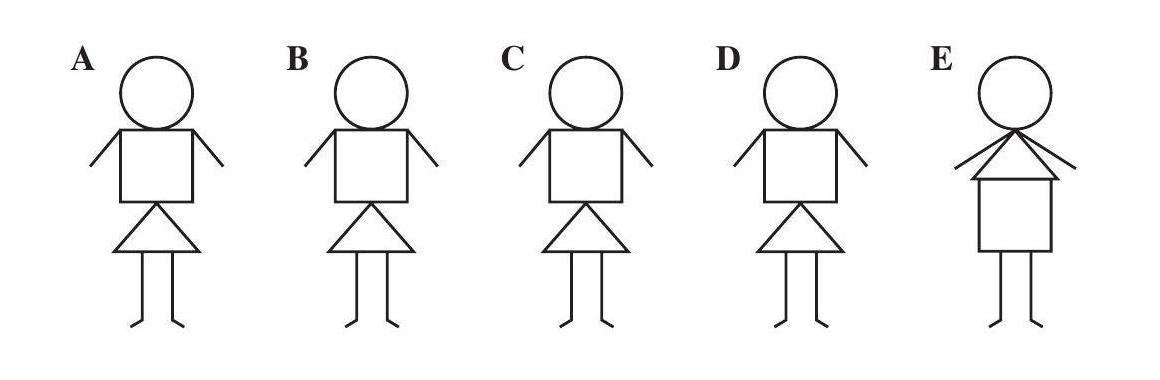


Response from the model:

The image displays five figures labeled A, B, C, D, and E. Each figure is a stick figure with a square body and triangular skirt, except for figure E, which has a rectangular body and no skirt. The question asks which figure differs from the others.

Upon examining the figures, we observe the following:
- Figures A, B, C, and D have square bodies and triangular skirts.
- Figure E has a rectangular body and no skirt.

Given that the other figures (A, B, C, and D) share the same design elements, the differing design elements of figure E make it the outlier.

Therefore, the figure that differs from the others is **E**.


In [12]:
system_prompt='You are solving logical reasoning problems.'
task = 'Which of these figures differ from the other four?'
image_path = './Pixtral_data/logical_reasoning.jpg'


print('Input Image:\n\n')
Image.open(image_path).show()

response = call_bedrock_model(model_id=endpoint_arn, 
                   prompt=task, 
                   system_prompt=system_prompt,
                   image_paths = image_path)

print(f'\nResponse from the model:\n\n{response}')


### Structured Product Information

Extracting product information is crucial for the retail industry, especially on platforms that host third-party sellers, where product images are the most accessible resource. Accurately capturing relevant details from these images is vital for a product's success in e-commerce. For instance, using advanced visual models like Pixtral 12B, retailers can efficiently extract key attributes from clothing product images, such as color, style, and patterns. This capability not only streamlines inventory management but also enhances customer experiences by providing essential information that aids in informed purchasing decisions.

Input Image:




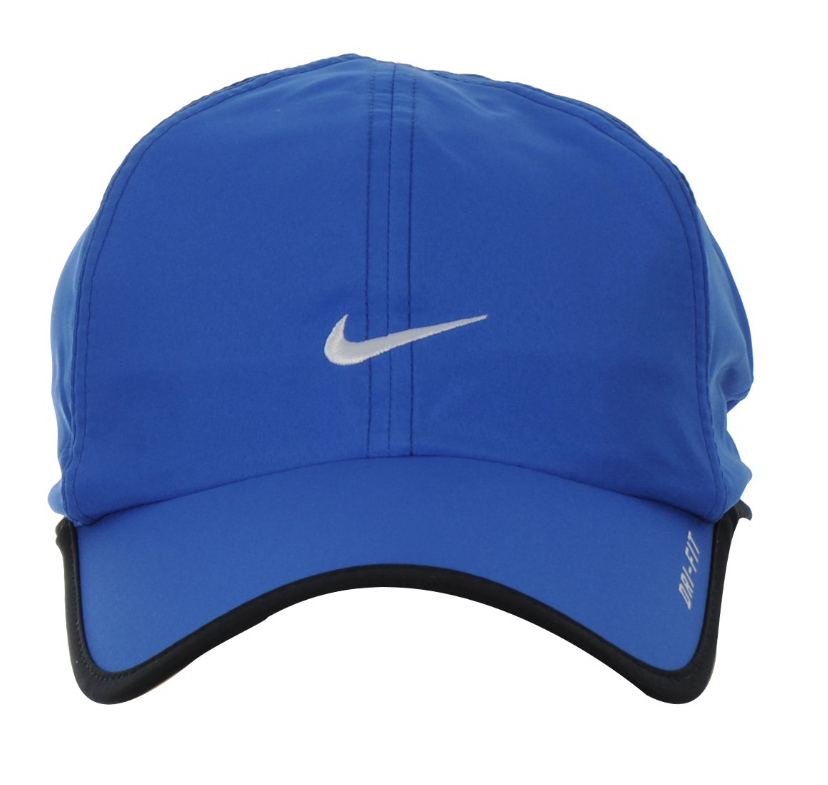


Response from the model:

Certainly! Based on the provided image, here is the extracted product information in JSON format:

```json
{
  "product_name": "Nike Running Cap",
  "description": "A lightweight and breathable running cap from Nike, perfect for outdoor activities.",
  "category": "Apparel",
  "sub_category": "Headwear",
  "color": "Blue",
  "size": "One Size",
  "brand": "Nike",
  "material": "Polyester",
  "features": [
    "Lightweight",
    "Breathable",
    "Moisture-wicking",
    "Adjustable fit"
  ],
  "image_alt_text": "A blue Nike running cap with the Nike logo in white."
}
```

This JSON format includes all the relevant product information that can be stored in a database.


In [13]:
system_prompt='''You are a catalog manager for an ecommerce portal. You have an image of a product. 
Think very carefully in a step-by-step manner to extract product information. 
Always provide response in prescribed JSON format.
'''
image_path = './Pixtral_data/cap.png'
task = '''
Organize product information in JSON format to store in a database. 

Output json schema:

{
"product_name": "",
"description": "",
"category": "",
"sub_category": "",
"color": "",
"size": "",
"brand": "",
"material": "",
"features": [],
"image_alt_text": ""
}
'''

print('Input Image:\n\n')
Image.open(image_path).show()

response = call_bedrock_model(model_id=endpoint_arn, 
                   prompt=task, 
                   system_prompt=system_prompt,
                   image_paths = image_path)

print(f'\nResponse from the model:\n\n{response}')


### Vehicle Damage Assessment

In the insurance industry, image analysis plays a crucial role in claims processing. For vehicle damage assessment, vision models like Pixtral 12B can be leveraged to compare images taken at policy issuance with those submitted during a claim. This approach can streamline the evaluation process, potentially reducing loss adjustment expenses and expediting claim resolution. By automating the identification and characterization of automobile damage, insurers can enhance efficiency, improve accuracy, and ultimately provide a better experience for policyholders.

Input Images:




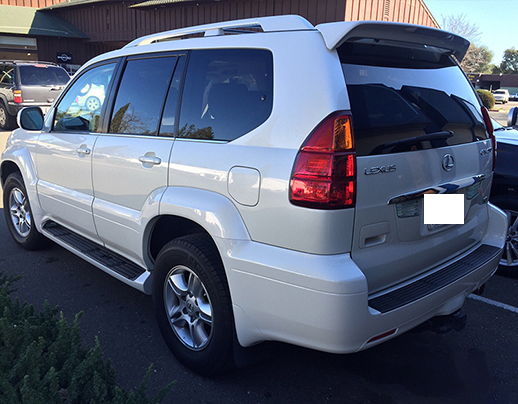

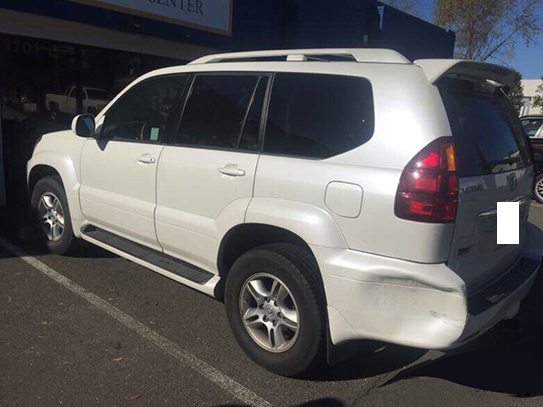


Response from the model:

Based on the provided images, here is the analysis:

1. **Description of Damage:**
   - In the "after the incident" image, there is visible damage to the rear bumper of the vehicle. The bumper appears to be dented and misaligned compared to the "before the incident" image.
   - The damage is localized to the rear bumper area, and no other visible damage is apparent from these images.

2. **Decision on Claim:**
   - The insurance agent should **accept the claim** for the vehicle damage. The images clearly show a difference in the condition of the rear bumper, indicating that damage occurred.
   - To proceed, the insurance agent should document the damage, assess the extent of the repair needed, and process the claim accordingly.

This analysis is based on the visual evidence provided. For a complete assessment, additional images and possibly an on-site inspection may be required.


In [14]:
image_paths = [
    "Pixtral_data/car_image_before.png",
    "Pixtral_data/car_image_after.png"
]

system_prompt='''
You are a helpful ai assistant for an insurance agent. 
Insurance agent has received a claim for a vehicle damage. 
'''

task = '''This claim includes two images. 
One of the image was taken before the incident and another was taken after the incident.

Analyse these images and answer below questions:
1. describe if there is any damage to the vehicle
2. should insurance agent accept or reject the claim

'''

print('Input Images:\n\n')
Image.open(image_paths[0]).show()
Image.open(image_paths[1]).show()

response = call_bedrock_model(model_id=endpoint_arn, 
                   prompt=task, 
                   system_prompt=system_prompt,
                   image_paths = image_paths)

print(f'\nResponse from the model:\n\n{response}')

### Handwriting Recognition

Another feature in Vision language models is their ability to recognise handwriting and extract handwritten text. Pixtral 12B performs well on extracting content from complex and poorly handwritten notes. 

Input Image:




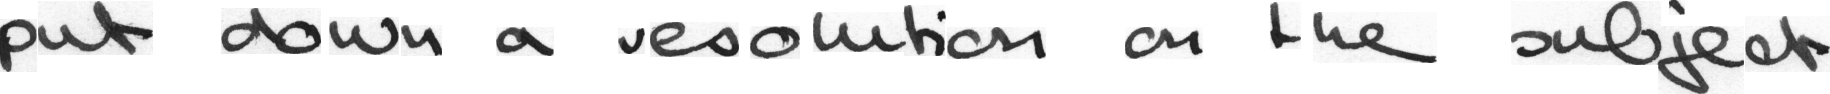


Response from the model:

put down a resolution on the subject


In [15]:
system_prompt='You are a Graphologists'
task = '''
Analyze the image and transcribe any handwritten text present. 
Convert the handwriting into a single, continuous string of text. 
Maintain the original spelling, punctuation, and capitalization as written. Ignore any printed text, drawings, or other non-handwritten elements in the image.
'''

image_path = './Pixtral_data/a01-000u-04.png'


print('Input Image:\n\n')
Image.open(image_path).show()

response = call_bedrock_model(model_id=endpoint_arn, 
                   prompt=task, 
                   system_prompt=system_prompt,
                   image_paths = image_path)

print(f'\nResponse from the model:\n\n{response}')


### Reasoning over complex figures

Vision Language Models (VLMs) excel at interpreting and reasoning about complex figures, charts, and diagrams. In this particular use case, we leverage Pixtral 12B, a powerful multimodal model, to analyze an intricate image containing GDP data. Pixtral 12B's advanced capabilities in document understanding and complex figure analysis make it well-suited for extracting insights from visual representations of economic data. By processing both the visual elements and  accompanying text, Pixtral 12B can provide detailed interpretations and reasoned analysis of the GDP figures presented in the image.


Input Image:




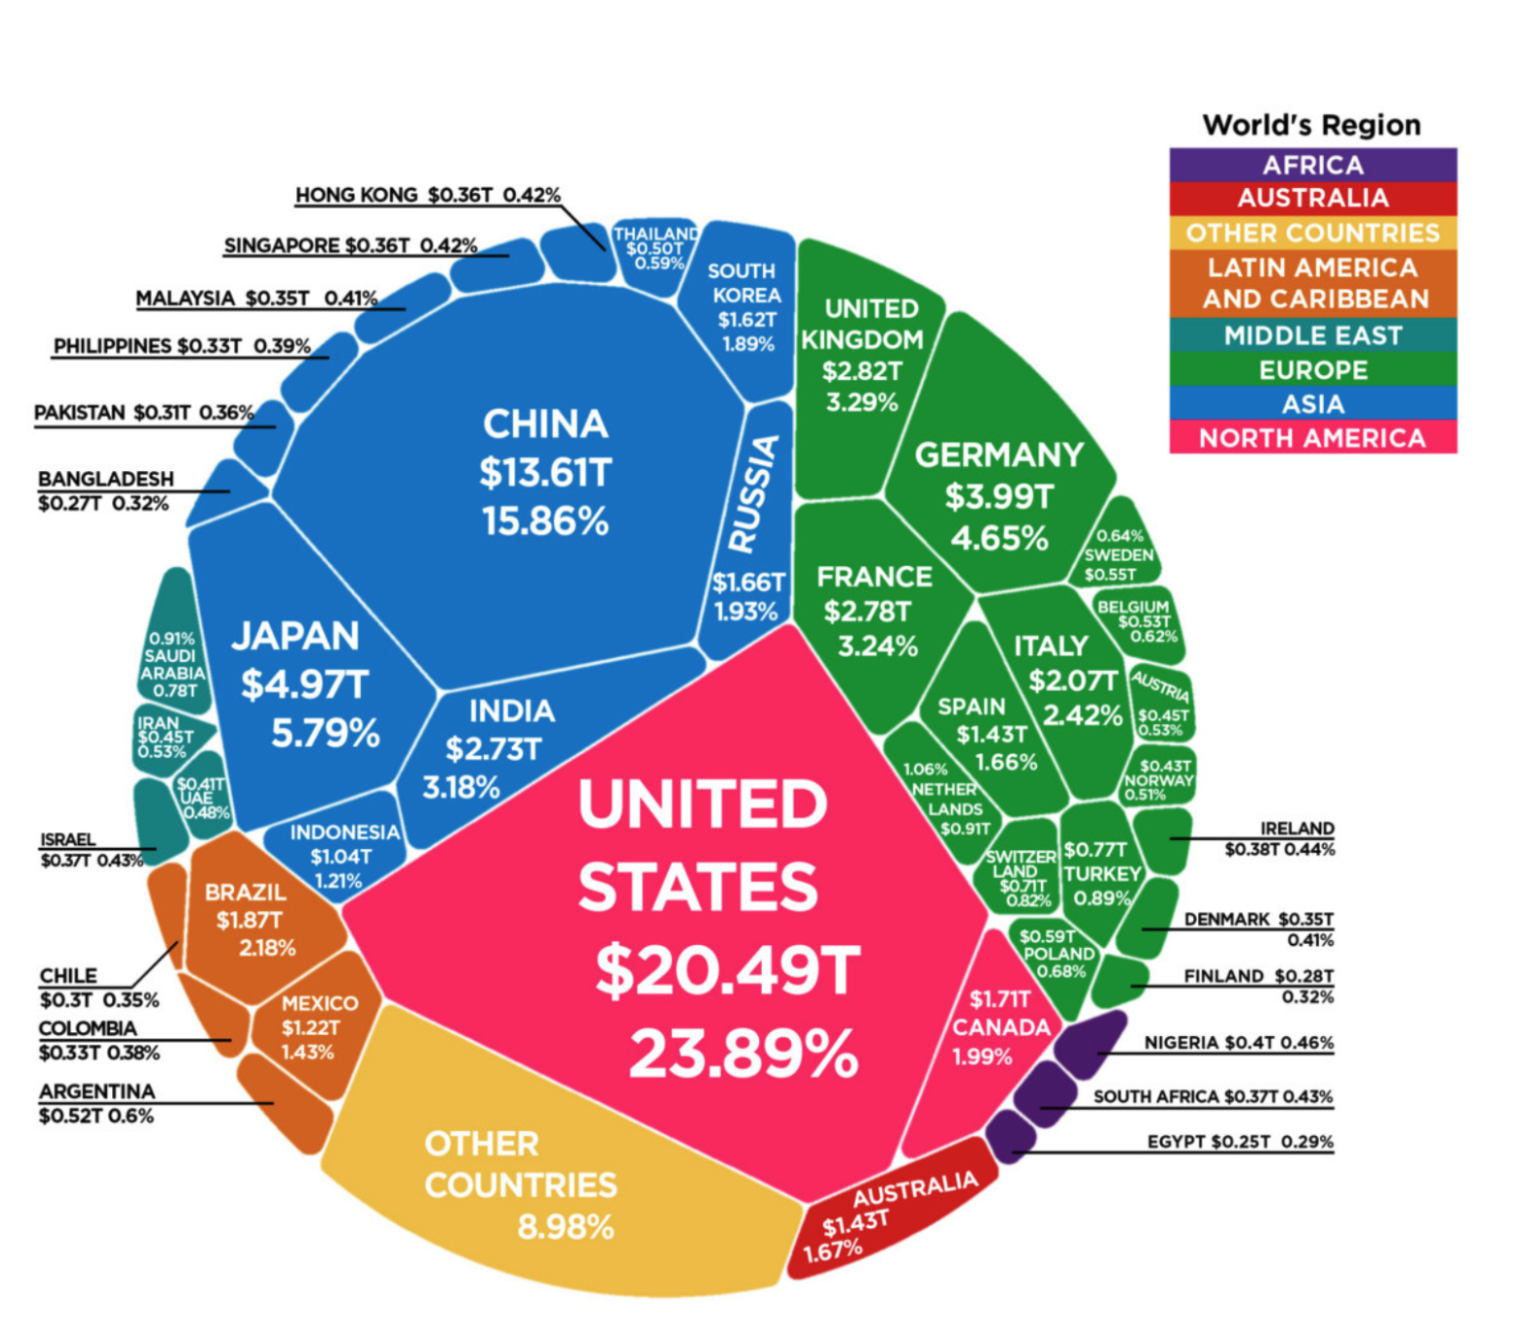


Response from the model:

The top 5 countries in Europe with the highest GDP, as indicated in the diagram, are:

1. **Germany**
   - GDP: $3.99 trillion
   - Percentage: 4.65%

2. **United Kingdom**
   - GDP: $2.82 trillion
   - Percentage: 3.29%

3. **France**
   - GDP: $2.78 trillion
   - Percentage: 3.24%

4. **Italy**
   - GDP: $2.07 trillion
   - Percentage: 2.42%

5. **Spain**
   - GDP: $1.43 trillion
   - Percentage: 1.66%

These countries are highlighted in green on the diagram.


In [16]:
system_prompt='You are a Global Economist.'
task = 'List the top 5 countries in Europe with the highest GDP'
image_path = './Pixtral_data/gdp.png'

print('Input Image:\n\n')
Image.open(image_path).show()

response = call_bedrock_model(model_id=endpoint_arn, 
                   prompt=task, 
                   system_prompt=system_prompt,
                   image_paths = image_path)

print(f'\nResponse from the model:\n\n{response}')


## Conclusion

In this notebook, we showed you how to get started with Pixtral 12B model in Bedrock and deploy the model for inference. Pixtral 12B vision model enables you to solve multiple use cases, including document understanding, logical reasoning, handwriting recognition, image comparison, entity extraction, extraction of structured data from scanned images and caption generation. These capabilities can drive productivity in a number of enterprise use cases, including ecommerce (retail), marketing, FSI and much more.

## Cleanup

It's important to cleanup the provisioned resources to avoid incurring costs. You have two options to delete the endpoint created in this notebook.

### Option 1 - Cleanup using AWS Console

In AWS Console, navigate to Amazon Bedrock service and click on Marketplace deployments under Foundation models. Here, select the deployed endpoint and click on Delete button. 

![Delete Endpoint](./Pixtral_data/br_marketplace_delete_endpoint.jpg)

Upon clicking the Delete button, a confirmation popup shows up. Here you read the warning carefully and confirm deletion.

### Option 2 - Cleanup using Bedrock SDK

You can run below cell to delete the endpoint.

In [17]:
bedrock_client.delete_marketplace_model_endpoint(endpointArn=endpoint_arn)

{'ResponseMetadata': {'RequestId': 'f4ceda50-e56e-4530-ab5f-24f556506dab',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Wed, 19 Feb 2025 06:36:24 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'f4ceda50-e56e-4530-ab5f-24f556506dab'},
  'RetryAttempts': 0}}